<a href="https://colab.research.google.com/github/Dhruv1603/Banana-Plant-Diseases/blob/main/Banana_Diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Banana Plant Diesases Predictions

###Database: https://www.kaggle.com/datasets/shifatearman/bananalsd

In [1]:
from google.colab import drive
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My Drive/BananaLSD/AugmentedSet/

/content/drive/My Drive/BananaLSD/AugmentedSet


In [4]:
def load_images_from_folder(folder):
  images = []
  labels = []
  for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    try:
      img = Image.open(img_path)
      images.append(np.array(img))
      labels.append(folder.split('/')[-1])  # Use folder name as label
    except IOError:
      print("Cannot load image:", img_path)
  return images, labels

In [5]:
cordana_images, cordana_labels = load_images_from_folder('/content/drive/My Drive/BananaLSD/AugmentedSet/cordana')
healthy_images, healthy_labels = load_images_from_folder('/content/drive/My Drive/BananaLSD/AugmentedSet/healthy')
pestalotiopsis_images, pestalotiopsis_labels = load_images_from_folder('/content/drive/My Drive/BananaLSD/AugmentedSet/pestalotiopsis')
sigatoka_images, sigatoka_labels = load_images_from_folder('/content/drive/My Drive/BananaLSD/AugmentedSet/sigatoka')

X_train = cordana_images + healthy_images + pestalotiopsis_images + sigatoka_images
Y_train = cordana_labels + healthy_labels + pestalotiopsis_labels + sigatoka_labels

print(f"Loaded {len(X_train)} images")
print(f"Loaded {len(Y_train)} labels")

Loaded 1600 images
Loaded 1600 labels


In [6]:
cordana_image, cordana_label = load_images_from_folder('/content/drive/My Drive/BananaLSD/OriginalSet/cordana')
healthy_image, healthy_label = load_images_from_folder('/content/drive/My Drive/BananaLSD/OriginalSet/healthy')
pestalotiopsis_image, pestalotiopsis_label = load_images_from_folder('/content/drive/My Drive/BananaLSD/OriginalSet/pestalotiopsis')
sigatoka_image, sigatoka_label = load_images_from_folder('/content/drive/My Drive/BananaLSD/OriginalSet/sigatoka')

X_test = cordana_image + healthy_image + pestalotiopsis_image + sigatoka_image
Y_test = cordana_label + healthy_label + pestalotiopsis_label + sigatoka_label

print(f"Loaded {len(X_test)} images")
print(f"Loaded {len(Y_test)} labels")

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:846: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Loaded 937 images
Loaded 937 labels


##Preprocessing

 1. **Data Preparation:**
   - It loads images of banana plants with various diseases (Cordana, healthy, Pestalotiopsis, Sigatoka) from a Google Drive directory.
   - It splits the data into training and testing sets.
   - It applies data augmentation techniques to increase the diversity of the training data and prevent overfitting.
   - It preprocesses the images by normalizing pixel values and scaling them.
   - It encodes the disease labels into numerical values.

In [7]:
# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Rotate images randomly by up to 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of the height
    shear_range=0.2,  # Apply shear transformations
    zoom_range=0.2,  # Zoom in or out by up to 20%
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill in any missing pixels after transformations
)

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Convert images to numpy arrays and normalize pixel values
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

# Encode labels
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

# Standardize the image data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[1] * X_train.shape[2] * X_train.shape[3])).reshape(-1, X_train.shape[1], X_train.shape[2], X_train.shape[3])
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[1] * X_test.shape[2] * X_test.shape[3])).reshape(-1, X_test.shape[1], X_test.shape[2], X_test.shape[3])

# Convert to tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train_tensor = tf.convert_to_tensor(Y_train_encoded, dtype=tf.int32)

X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test_tensor = tf.convert_to_tensor(Y_test_encoded, dtype=tf.int32)

print(f"X_train shape: {X_train_tensor.shape}")
print(f"Y_train shape: {Y_train_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}")
print(f"Y_test shape: {Y_test_tensor.shape}")

X_train shape: (1600, 224, 224, 3)
Y_train shape: (1600,)
X_test shape: (937, 224, 224, 3)
Y_test shape: (937,)


##Model Train

2. **Model Building:**
   - It utilizes a pre-trained ResNet101 convolutional neural network as a base model.
   - It adds custom layers on top of the pre-trained model for classification.
   - It initially freezes the weights of the pre-trained layers to avoid disrupting their learned features during the initial training phase.
   - It compiles the model with an appropriate


In [16]:
# Load the pre-trained ResNet101 model (without the top classification layer)
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 77,052,366 (293.93 MB)

 Trainable params: 16,829,636 (64.20 MB)

 Non-trainable params: 26,563,456 (101.33 MB)

 Optimizer params: 33,659,274 (128.40 MB)

In [17]:
# Train the model
history = model.fit(X_train_tensor, Y_train_tensor, epochs=20, batch_size=16)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.5555 - loss: 1.0067
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8158 - loss: 0.4668
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.8486 - loss: 0.4209
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.8769 - loss: 0.3625
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8989 - loss: 0.2716
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.8888 - loss: 0.2864
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9175 - loss: 0.2205
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9407 - loss: 0.1668
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9531 - loss: 0.1431
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9304 - loss: 0.2026
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9616 - loss: 0.1179
Epoch 12/20
100/100 ━━━━━━━━━━━━━━

##Model Test

3. **Model Training:**
   - The model is trained on the prepared dataset using the `model.fit()` method.
   - It tracks the accuracy and loss during training to monitor its performance.

4. **Model Evaluation:**
   - The model's performance is evaluated on the test set to measure its ability to correctly classify unseen images.
   - It calculates the accuracy and loss on the test set.

In [18]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_tensor, Y_test_tensor)
print("Test Accuracy:", accuracy)
print("Test Loss:", loss)

30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.9162 - loss: 0.6655
Test Accuracy: 0.9199573397636414
Test Loss: 0.41039469838142395


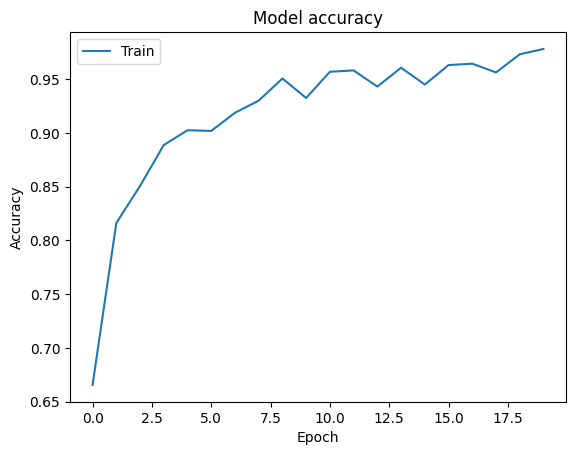

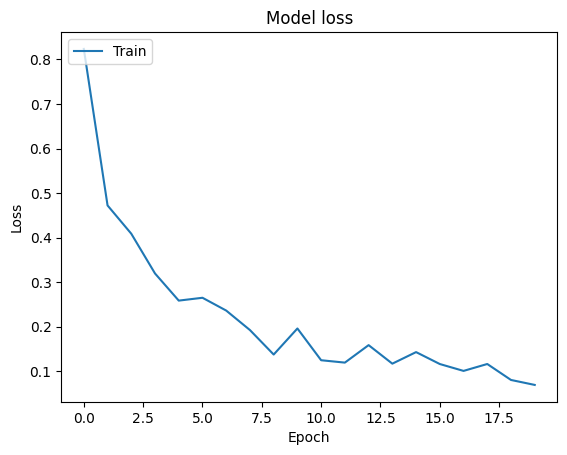

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


5. **Model Visualization:**
   - It plots the training accuracy and loss over epochs to visualize the model's learning progress.
   - It displays a few images from the test set with their original and predicted labels.

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 388ms/step


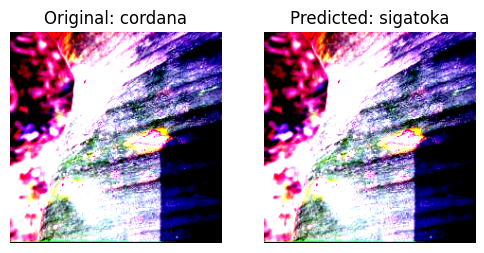

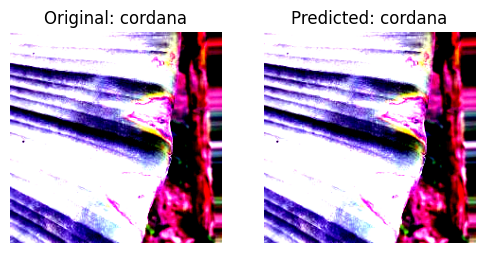

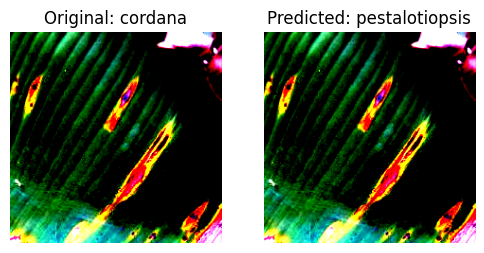

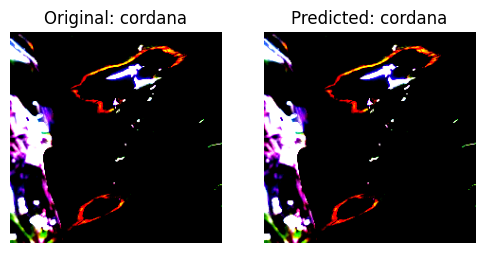

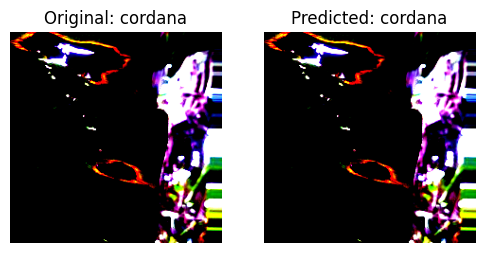

In [21]:
# Get predictions for the test set
Y_pred_encoded = np.argmax(model.predict(X_test_tensor), axis=1)

# Decode the predicted and true labels
Y_pred = label_encoder.inverse_transform(Y_pred_encoded)
Y_test_decoded = label_encoder.inverse_transform(Y_test_encoded)

# Display a few images with original and predicted labels
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i])
    plt.title(f"Original: {Y_test_decoded[i]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(X_test[i])
    plt.title(f"Predicted: {Y_pred[i]}")
    plt.axis('off')

    plt.show()

##Fine - Tuning Model

7. **Model Saving:**
   - Finally, the trained model is saved to a file for future use in classifying new banana plant images.


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 272ms/step - accuracy: 0.5296 - loss: 14.3521 - val_accuracy: 0.8399 - val_loss: 1.2492
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.8421 - loss: 1.2751 - val_accuracy: 0.8346 - val_loss: 1.4761
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.8921 - loss: 0.6029 - val_accuracy: 0.8399 - val_loss: 1.5283
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.9431 - loss: 0.3049 - val_accuracy: 0.8666 - val_loss: 1.4151
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.9477 - loss: 0.2722 - val_accuracy: 0.8741 - val_loss: 1.3206
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.9570 - loss: 0.1602 - val_accuracy: 0.8858 - val_loss: 1.2278
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.9723 - loss: 0.0933 - val_accuracy: 0.8805 - val_loss: 1.2103
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.9721 - loss: 

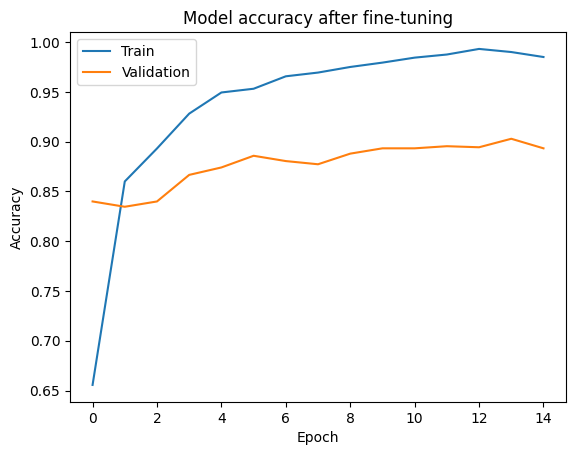

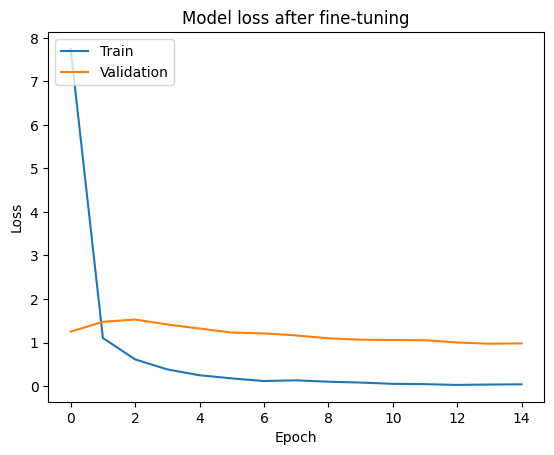

In [27]:
# Unfreeze some of the top layers of the pre-trained model for fine-tuning
for layer in model.layers[-50:]:
    layer.trainable = True

# Compile the model again with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(X_train_tensor, Y_train_tensor,
                              epochs=15,
                              batch_size=16,
                              validation_data=(X_test_tensor, Y_test_tensor))

# Evaluate the model on the test set after fine-tuning
loss, accuracy = model.evaluate(X_test_tensor, Y_test_tensor)
print("Test Accuracy after Fine-tuning:", accuracy)
print("Test Loss after Fine-tuning:", loss)

# Plot training and validation accuracy and loss after fine-tuning
plt.plot(fine_tune_history.history['accuracy'])
plt.plot(fine_tune_history.history['val_accuracy'])
plt.title('Model accuracy after fine-tuning')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(fine_tune_history.history['loss'])
plt.plot(fine_tune_history.history['val_loss'])
plt.title('Model loss after fine-tuning')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

7. **Model Saving:**
   - Finally, the trained model is saved to a file for future use in classifying new banana plant images.


###Save the model

In [29]:
# Save the model
model.save('/content/drive/My Drive/BananaLSD/banana_disease_model.h5')

##Eschatology

**In essence, this project demonstrates a standard workflow for image classification using transfer learning and deep learning techniques.** It effectively tackles the problem of banana plant disease identification, which is crucial for agricultural management and yield optimization.